# Health Insurance Cost Prediction

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read in the data
insurance = pd.read_csv('insurance.csv')

In [4]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploratory Data Analysis

In [5]:
# describe the numerical data
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# no null values
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

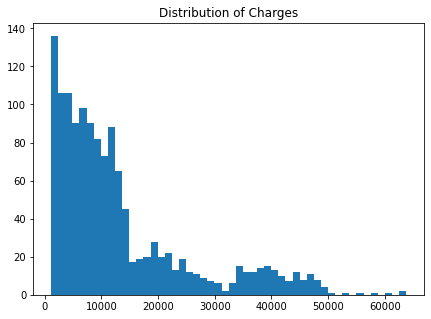

In [7]:
plt.figure(figsize = (7,5))
plt.hist(insurance['charges'], bins = 50)

plt.title('Distribution of Charges')
plt.show()

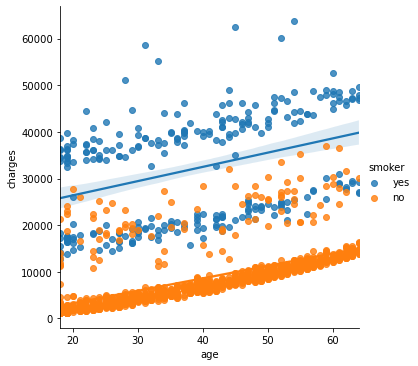

In [8]:
# scatterplot of ages
# very big difference between nonsmokers and smokers in charges
# charges increase gradually with age
sns.lmplot(x = 'age', y = 'charges', data = insurance, hue = 'smoker')

In [9]:
# check costs by sex
# men have slightly higher costs
insurance.groupby('sex')['charges'].mean()

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

In [10]:
# check costs by number of children
# people with 4 or 5 children have lower charges on average
# does not have zero conditional mean
# may have to create bins for number of children
insurance.groupby('children')['charges'].mean()

children
0    12365.975602
1    12731.171832
2    15073.563734
3    15355.318367
4    13850.656311
5     8786.035247
Name: charges, dtype: float64

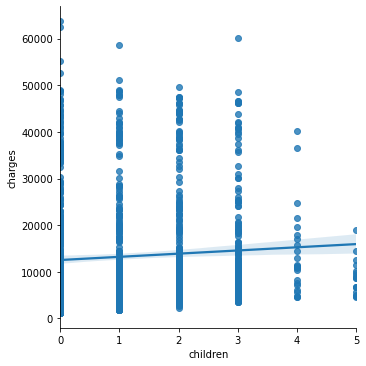

In [11]:
sns.lmplot(x = 'children', y = 'charges', data = insurance)

In [12]:
# check costs of smokers
# smokers have significantly higher costs
insurance.groupby('smoker')['charges'].mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

In [13]:
# check number of smokers
insurance['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [14]:
# check costs by region
# Southwest has lowest, Southeast has highest charges
insurance.groupby('region')['charges'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

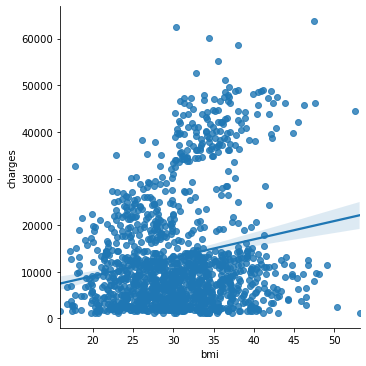

In [15]:
# make scatterplot of bmi to charges
# heteroskedastic in nature
sns.lmplot(x = 'bmi', y = 'charges', data = insurance)

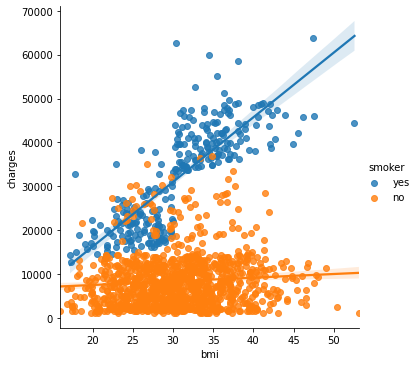

In [16]:
# scatterplot with hue for smoker
# non smokers and smokers have a very clearly defined difference of relationship between bmi and charges
# potentially include bmi * smoker as an interaction term
sns.lmplot(x = 'bmi', y = 'charges', data = insurance, hue = 'smoker')

### Set up the data for modelling

In [17]:
# create dummy variables
dummies = pd.get_dummies(insurance[['sex', 'smoker', 'region']], drop_first = True)
insurance = pd.concat([insurance, dummies], axis = 1)

In [18]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

In [31]:
from sklearn.model_selection import train_test_split

X = insurance[['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 
               'region_northwest', 'region_southeast', 'region_southwest']]
y = insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [35]:
import statsmodels.api as sm

# view regression
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     333.9
Date:                Tue, 27 Jul 2021   Prob (F-statistic):          6.51e-267
Time:                        12:32:39   Log-Likelihood:                -9492.8
No. Observations:                 936   AIC:                         1.900e+04
Df Residuals:                     927   BIC:                         1.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.237e+04   1210.540  

In [39]:
from sklearn.linear_model import LinearRegression

# perform first linear regression
lm = LinearRegression()
model = lm.fit(X_train, y_train)

In [40]:
predictions = model.predict(X_test)

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# find root mean squared error and r^2 of predictions
rmse = mean_squared_error(y_test, predictions, squared = False)
r2 = r2_score(y_test, predictions)

print('RMSE: ', round(rmse, 4))
print('R^2: ', round(r2, 4))

RMSE:  5812.1003
R^2:  0.7696


In [38]:
from sklearn import linear_model

# we perform lasso regression over alphas from 0.1 to 5 and find that the RMSE does not change significantly over the values
lasso_mse = []
alphas = np.arange(0.1, 5, 0.2)
for a in alphas:
    clf = linear_model.Lasso(alpha = a)
    clf.fit(X_train, y_train)
    predictions_linear_model = clf.predict(X_test)
    lasso_mse.append(np.round(mean_squared_error(predictions_linear_model, y_test, squared = False), decimals = 3))

print(lasso_mse)

[5812.098, 5812.092, 5812.087, 5812.083, 5812.079, 5812.075, 5812.071, 5812.068, 5812.065, 5812.063, 5812.061, 5812.059, 5812.058, 5812.057, 5812.056, 5812.055, 5812.055, 5812.055, 5812.056, 5812.057, 5812.059, 5812.061, 5812.063, 5812.066, 5812.068]


In [25]:
from sklearn.ensemble import RandomForestRegressor

# perform first random forest regression
rf = RandomForestRegressor()
model = rf.fit(X_train, y_train)

In [26]:
predictions = model.predict(X_test)

In [27]:
# find root mean squared error and r^2 of predictions
# we find that the random forest has much lower RMSE and higher R^2
rmse = mean_squared_error(y_test, predictions, squared = False)
r2 = r2_score(y_test, predictions)

print('RMSE: ', round(rmse, 4))
print('R^2: ', round(r2, 4))

RMSE:  4621.3604
R^2:  0.8543


In [62]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits = k)
model = RandomForestRegressor()

rmse_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, predictions, squared = False)
    rmse_list.append(rmse)
    
avg_rmse = sum(rmse_list)/k

print('RMSE of each fold: ', rmse_list)
print('Average RMSE: ', avg_rmse)

RMSE of each fold:  [4821.538934246543, 5399.576504709789, 4373.333799862265, 5010.443242859759, 4812.6356773233465]
Average RMSE:  4883.50563180034
